# Mapping and Prediction of Incised Features.

In [1]:
%%capture

# NOTE: CAN CONSIDER PULLING STEP 3 (9x9m) DOWN INTO FINEST SCALE STEP BECAUSE PROFILE CURVATURE IS STILL RELEVANT
# AT THIS SCALE. CURRENTLY PROFILE CURVATURE IS ONLY USED AT STEP 1 AND 2.
from siphon.catalog import TDSCatalog 
import sklearn
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
import seaborn as sns; sns.set()
import pandas as pd
import random
import numpy as np
import xarray as xr
import scipy
import gdal
from scipy.ndimage.filters import uniform_filter
from scipy import ndimage
from scipy.ndimage.filters import *
import os
import math
from osgeo import osr
from fractions import Fraction
import timeit
import matplotlib.pyplot as plt
#import matplotlib.image as mpimg
%matplotlib inline

# import plotting tools
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
from matplotlib import cm
from matplotlib.ticker import LinearLocator, FormatStrFormatter
import matplotlib as mpl
from landlab.plot.imshow import imshow_grid 
from landlab.plot.imshow import imshow_node_grid 
# import necessary landlab components
from landlab import RasterModelGrid, HexModelGrid
from landlab.components import FlowAccumulator, FlowRouter, SinkFiller
from landlab.components import(FlowDirectorD8, 
                               FlowDirectorDINF, 
                               FlowDirectorMFD, 
                               FlowDirectorSteepest)
from landlab.components import DepressionFinderAndRouter
# import landlab plotting functionality
from landlab.plot.drainage_plot import drainage_plot
from pylab import show, figure
#, x1 = None, x2 = None, y1 = None, y2 = None
# create a plotting routine to make a 3d plot of our surface. 
def surf_plot(mg, surface='topographic__elevation', 
              title='Surface plot of topography', colormap = cm.gray):
    
    fig = plt.figure()
    ax = fig.gca(projection='3d')

    # Plot the surface.
    Z = (mg.at_node[surface].reshape(mg.shape))#[y1:y2, x1:x2]
    color = colormap((Z-Z.min())/(Z.max()-Z.min()))
    surf = ax.plot_surface(mg.node_x.reshape(mg.shape),#[y1:y2, x1:x2]
                           mg.node_y.reshape(mg.shape),#[y1:y2, x1:x2]
                           Z,
                           rstride=1, cstride=1,
                           facecolors=color,
                           linewidth=0.,
                           antialiased=False)
    ax.view_init(elev=35, azim=-120)
    ax.set_xlabel('X axis')
    ax.set_ylabel('Y axis')
    ax.set_zlabel('Elevation')
    plt.title(title)
    plt.show()

In [3]:
sample_results = {}
sample_results.setdefault('sample', []);
sample_results.setdefault('mapilf_index', []);
sample_results.setdefault('topo_index', []);
sample_results.setdefault('slope', []);
sample_results.setdefault('slope_class', []);
#sample_results.setdefault('topo_index_class', []);
sample_results.setdefault('landcover', []);

In [24]:
level_of_generalisation = 6
location = (r'D:/PhD/junk')
os.chdir(location)
input_geotiff = gdal.Open('bfs8_sub2.tif')
initial_resolution = 1
x = np.array(input_geotiff.GetRasterBand(1).ReadAsArray())
input_DEM = x
kernel = np.loadtxt('kernel.txt')
kernel_1d = np.reshape(kernel,(1,121))

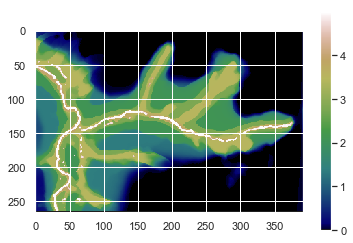

In [25]:
plt.imshow(input_DEM, cmap="gist_earth")
plt.colorbar()

In [26]:
potential = (input_DEM >=2.5).sum()
actual = (input_DEM >=3.5).sum()
MAPILF_index = (potential - actual)/(potential)

In [27]:
MAPILF_index

0.83152264057057557

In [32]:
for (dirpath, dirnames, filenames) in os.walk('.'):
    for file in filenames:
        if file.endswith('.shp'):
            item = file[:-4]
            sample_results['sample'].append(item)
            ds = gdal.Open(item + '_m.tif')
            initial_resolution = 1
            MAPILF = np.array(ds.GetRasterBand(1).ReadAsArray())
            slope_ds = gdal.Open(item + '_s.tif')
            initial_resolution = 1
            slope = np.array(slope_ds.GetRasterBand(1).ReadAsArray())
            topo_ds = gdal.Open(item + '_twi.tif')
            initial_resolution = 1
            topo = np.array(topo_ds.GetRasterBand(1).ReadAsArray())
            potential = (MAPILF >=1.5).sum()
            actual = (MAPILF >=3.5).sum()
            MAPILF_index = (potential - actual)/(potential)
            sample_results['mapilf_index'].append(MAPILF_index)
            topo[topo < 0] = np.nan
            topo_stat = np.nanpercentile(topo, 25)
            sample_results['topo_index'].append(topo_stat)
            sample_results['landcover'].append(landcover_type)
            slope[slope < 0] = np.nan
            slope_stat = np.nanmean(slope)
            sample_results['slope'].append(slope_stat)
    
            if 0 < slope_stat < 3:
                sample_results['slope_class'].append(1)
            elif 3 < slope_stat < 6:
                sample_results['slope_class'].append(2)
            elif 6 < slope_stat < 9:
                sample_results['slope_class'].append(3)
            elif 9 < slope_stat < 12:
                sample_results['slope_class'].append(4)
            elif 12 < slope_stat < 15:
                sample_results['slope_class'].append(5)
            elif 15 < slope_stat < 18:
                sample_results['slope_class'].append(6)
            elif slope_stat > 18:
                sample_results['slope_class'].append(7)
            else:
                sample_results['slope_class'].append(8);
        


In [33]:
df = pd.DataFrame(data = sample_results);
df.replace([np.inf, -np.inf], np.nan)
results_table = df.dropna();
MAPILF_mean = results_table['mapilf_index'].mean();

In [2]:
results_by_slope = results_table.groupby(['slope_class', 'landcover'])
results_by_slope.count()

NameError: name 'results_table' is not defined

In [55]:
results_by_slope = results_table.groupby(['slope_class'])
results_by_slope.mean()

,mapilf_index,topo_index,slope
slope_class,,,
1,0.974476,7.304996,2.992552
2,0.824714,6.335487,4.793773
3,0.742778,5.684394,7.691750
4,0.688254,5.275788,10.546409
5,0.639492,4.931705,13.606079
6,0.636388,4.701206,16.390446
7,0.642769,4.538223,19.645225


## Randomisation samples

In [195]:
dfs = results_table.query("slope_class == 3")

In [196]:
a = dfs["mapilf_index"].mean() - 0.005
b = dfs["mapilf_index"].mean() + 0.005

In [197]:
list_results = []
for i in range(0, 50000):
    randomisation = dfs.sample(20)
    mu = randomisation.mean()
    if mu[0] > a and mu[0] < b:
        train, test = train_test_split(randomisation, test_size = 0.5)
        diff = train.mean()[0] - test.mean()[0]
        list_results.append(diff)

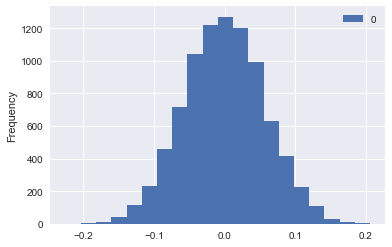

In [198]:
dfl = pd.DataFrame(data = list_results)
dfl.plot(kind = 'hist', bins = 20)

In [199]:
xc = np.array(dfl[0])
xcm = (xc > 0.041).sum()
xcs = xc.size
xc_prop = xcm / xcs
xc_prop

0.23354321694333144

## Bootstraping after shifting mean

In [ ]:
# Take difference between average of forested and average of cleared. 
# Add difference to each sample in the cleared group and then bootstrap.

In [246]:
dfs = results_table.query("slope_class == 5")
dfor = dfs.query("landcover == 'forest'")
dclr = dfs.query("landcover == 'cleared'")
mu_dclr = dclr["mapilf_index"].mean()
mu_dfor = dfor["mapilf_index"].mean()
diff = mu_dfor - mu_dclr
diff

0.09284321270281792

In [247]:
clear_mean = dclr['mapilf_index'].mean()
clear_mean

0.6026391450518411

In [248]:
adjusted_clear = np.array(dclr['mapilf_index']) + diff

In [249]:
pac = pd.DataFrame(adjusted_clear)

In [7]:
l = [1,2,3]
np.mean(l)

2.0

In [250]:
mean_of_shifted = []
for i in range(0, 10000):
    sample_mean_list = []
    for f in range(0, size of sample):
        randomisation = pac.sample(1)
        sample_mean.append(randomisation)
    sample_mean = 

    mean_of_shifted.append(mu)

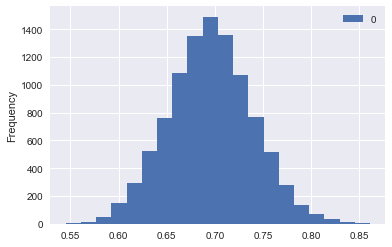

In [251]:
dfl = pd.DataFrame(data = mean_of_shifted)
dfl.plot(kind = 'hist', bins = 20)

In [252]:
xc = np.array(dfl[0])
xcm = (xc < clear_mean).sum()
xcs = xc.size
xc_prop = xcm / xcs
xc_prop

0.0147

In [177]:
linreg = LinearRegression()

In [178]:
predictor =  np.array(results_table[['topo_index']])
predictand = np.array(results_table[['mapilf_index']])


In [179]:
model = linreg.fit(predictor, predictand)

In [180]:
model.score(predictor, predictand)

0.12560568819352247

In [181]:
regress_slope = linreg.coef_[0][0]
regress_slope

0.080911930715206401

In [182]:
frst = results_table.loc[(results_table.landcover == 'forest')]
clr = results_table.loc[(results_table.landcover == 'cleared')]

Text(0,0.5,'MAPILF Index')

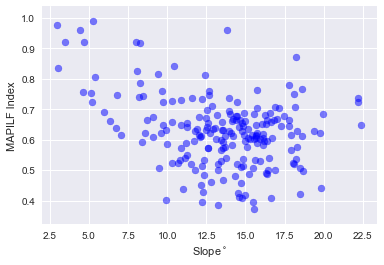

In [183]:
fig = plt.figure()
ax = plt.gca()
ax.scatter(clr['slope'], clr['mapilf_index'], c = 'blue', alpha = 0.5)
#ax.set_xscale('log')
ax.set_xlabel('Slope' + '$^\circ$')
ax.set_ylabel('MAPILF Index')

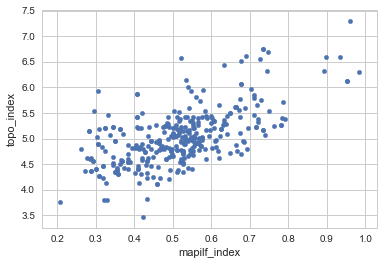

In [203]:
results_table.plot.scatter(x = 'mapilf_index', y = 'topo_index')

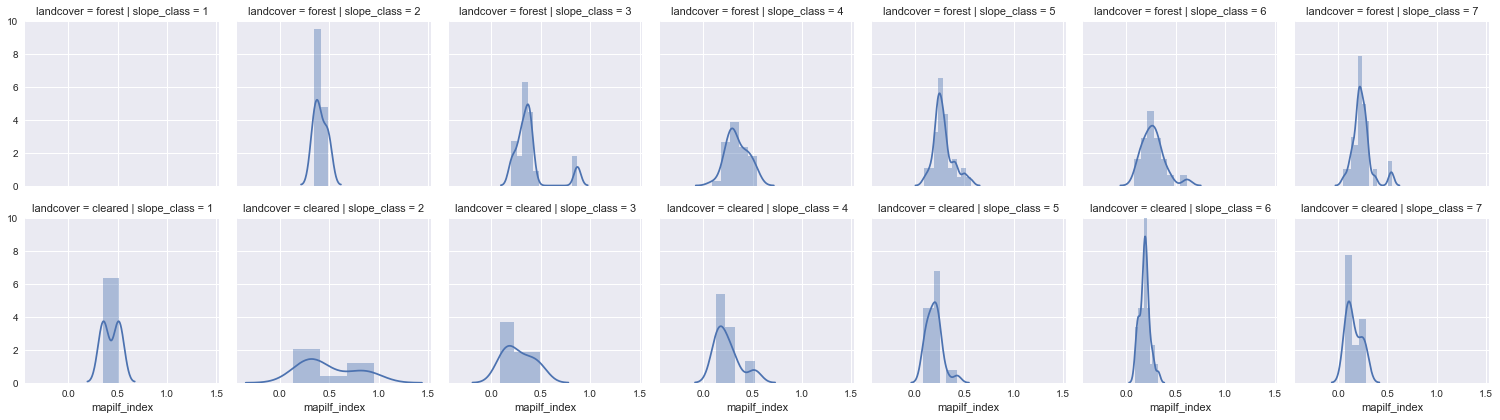

In [363]:
sns.set(style = "darkgrid")
g = sns.FacetGrid(results_table, row = 'landcover', col = 'slope_class')
g.map(sns.distplot, "mapilf_index")
plt.show()

In [40]:
slope_A = results_table.loc[(results_table.slope_class == 1)]
slope_B = results_table.loc[(results_table.slope_class == 2)]
slope_C = results_table.loc[(results_table.slope_class == 3)]
slope_D = results_table.loc[(results_table.slope_class == 4)]
slope_E = results_table.loc[(results_table.slope_class == 5)]
slope_F = results_table.loc[(results_table.slope_class == 6)]

Text(0,0.5,'TWI')

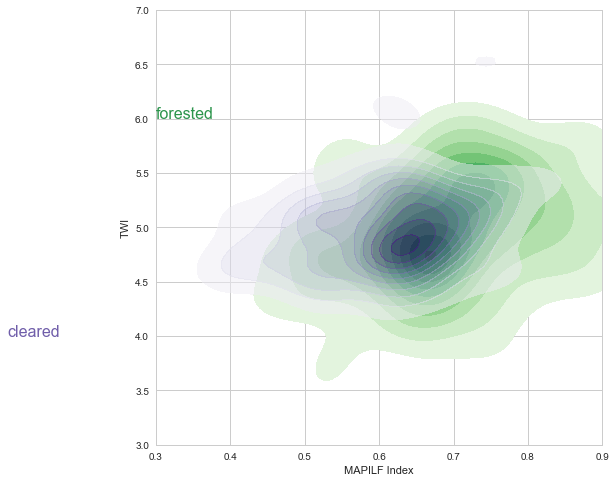

In [142]:
sns.set(style = "whitegrid")
forested = results_table.query("landcover == 'forest'")
cleared = results_table.query("landcover == 'cleared'")

# Set up the figure
f, ax = plt.subplots(figsize=(8, 8))
ax.set_aspect("auto")

# Draw the two density plots
ax = sns.kdeplot(forested.mapilf_index, forested.topo_index,
                 cmap="Greens", shade=True, shade_lowest=False)
ax = sns.kdeplot(cleared.mapilf_index, cleared.topo_index,
                 cmap="Purples", shade=True, shade_lowest=False, alpha = 0.5)

# Add labels to the plot
green = sns.color_palette("Greens")[-2]
purple = sns.color_palette("Purples")[-2]
ax.text(0.3, 6, "forested", size=16, color=green)
ax.text(0.1, 4, "cleared", size=16, color=purple)
plt.xlim(0.3, 0.9)
plt.ylim(3, 7)
ax.set_xlabel('MAPILF Index')
ax.set_ylabel('TWI')

Text(17.2,0.5,'TWI')

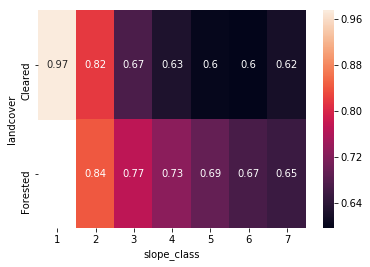

In [56]:
gh = results_table.pivot_table(index = 'landcover', columns = 'slope_class',
                               values = 'mapilf_index', aggfunc = np.mean)
sns.heatmap(gh, annot = True)
ax.set_xlabel('MAPILF Index')
ax.set_ylabel('TWI')

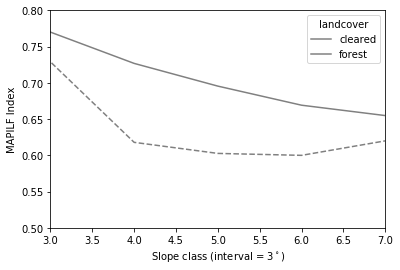

In [56]:
fig, ax = plt.subplots()
results_table.groupby(['slope_class',
                       'landcover']).mean()['mapilf_index'].unstack().plot(ax=ax, color = "grey", kind = 'line')
ax.set_xlabel('Slope class (interval = 3$^\circ$)')
ax.set_ylabel('MAPILF Index')
plt.xlim(3, 7)
plt.ylim(.5, .8)
ax.lines[0].set_linestyle("--")


In [144]:
slope_subset = results_table.query("slope_class >= 2")

(0.5516240218121691, 0.9313620847016727)

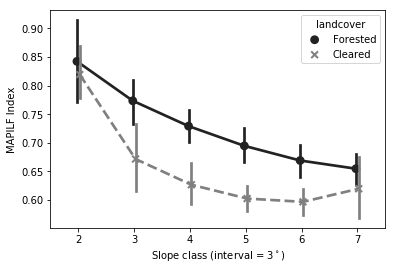

In [60]:
ax = sns.pointplot(x = "slope_class", y = "mapilf_index", hue = "landcover", data = slope_subset,
                  markers = ["o", "x"],
                  linestyles = ["-", "--"],
                  color = "grey",
                  dodge = True)
ax.set_xlabel('Slope class (interval = 3$^\circ$)')
ax.set_ylabel('MAPILF Index')
plt.xlim()
plt.ylim()

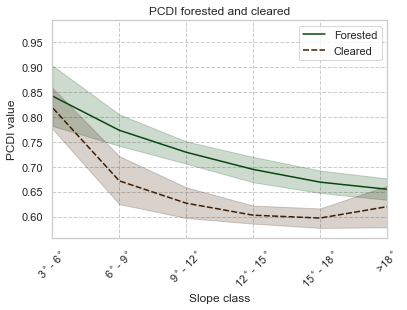

In [150]:
sns.set(style = "whitegrid")
from matplotlib.ticker import ScalarFormatter
#colors = ['cherry red']
colors = ["forest green", "chocolate"]
#colors = ['forest green', 'leaf green', 'moss green', 'greenish']
palette = sns.xkcd_palette(colors)
ax = sns.lineplot(x = "slope_class", y = "mapilf_index", palette = palette,  hue = "landcover", 
                  data = df, style = "landcover", ci = 90)
ax.set_xlim(2, 7)

ax.set(xlabel = 'Slope class')
ax.set(ylabel = 'PCDI value')
plt.title('PCDI forested and cleared')
ax.grid(which='major', axis='both', linestyle='--')
#ax.grid(False, axis='x')
ticks = ['3$^\circ$- 6$^\circ$', '6$^\circ$- 9$^\circ$', '9$^\circ$- 12$^\circ$',
         '12$^\circ$- 15$^\circ$', '15$^\circ$- 18$^\circ$', '>18$^\circ$']
ax.set_xticklabels(ticks, rotation = 45)
ax.legend(['Forested',  
           'Cleared'])

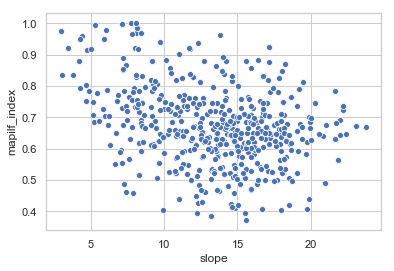

In [139]:
sns.set(style = "whitegrid")
from matplotlib.ticker import ScalarFormatter

ax = sns.scatterplot(data = df, x = 'slope', y = 'mapilf_index')
#ax.set_xscale('log')

In [147]:
forested = results_table.query("landcover == 'forest'")
cleared = results_table.query("landcover == 'cleared'")

(0.22975237260492276, 1.142777271663852)

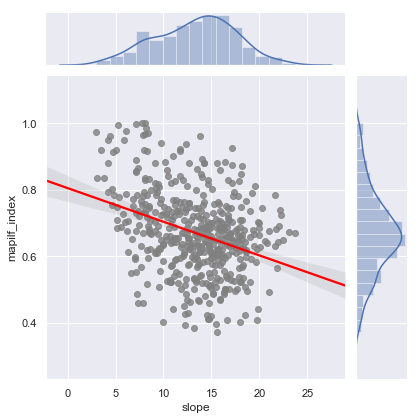

In [110]:
sns.set(style = "darkgrid")
g = sns.jointplot(x="slope", y="mapilf_index", data=results_table, kind='reg',
                  joint_kws={'color':'grey'}) # Scatter and regression all green
regline = g.ax_joint.get_lines()[0]
regline.set_color('red')
plt.xlim()
plt.ylim()

In [35]:
subset_results = results_table.query("slope_class == 7")

In [115]:
forested = results_table.query("landcover == 'Forest'")
cleared = results_table.query("landcover == 'Cleared'")

[Text(0,0,'3$^\\circ$- 6$^\\circ$'),
 Text(0,0,'6$^\\circ$- 9$^\\circ$'),
 Text(0,0,'9$^\\circ$- 12$^\\circ$'),
 Text(0,0,'12$^\\circ$- 15$^\\circ$'),
 Text(0,0,'15$^\\circ$- 18$^\\circ$'),
 Text(0,0,'>18$^\\circ$')]

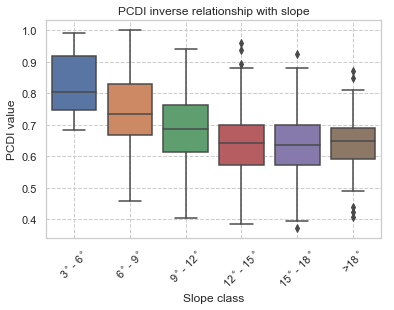

In [148]:
sns.set(style = "whitegrid")
from matplotlib.ticker import ScalarFormatter
#colors = ['cherry red']
colors = ["grey"]
#colors = ['forest green', 'leaf green', 'moss green', 'greenish']
palette = sns.xkcd_palette(colors)
ax = sns.boxplot(x="slope_class", y = "mapilf_index", data = slope_subset)
#ax.set_xlim(2, 7)
ax.set(xlabel = 'Slope class')
ax.set(ylabel = 'PCDI value')
plt.title('PCDI inverse relationship with slope')
ax.grid(which='major', axis='both', linestyle='--')
#ax.grid(False, axis='x')
ticks = ['3$^\circ$- 6$^\circ$', '6$^\circ$- 9$^\circ$', '9$^\circ$- 12$^\circ$',
         '12$^\circ$- 15$^\circ$', '15$^\circ$- 18$^\circ$', '>18$^\circ$']
ax.set_xticklabels(ticks, rotation = 45)


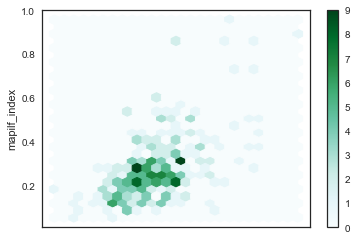

In [394]:
vis = results_table[['landcover', 'mapilf_index', 'slope', 'topo_index']]
vis.plot.hexbin(x = 'topo_index', y = 'mapilf_index', gridsize = 25)

Text(17.2,0.5,'TWI')

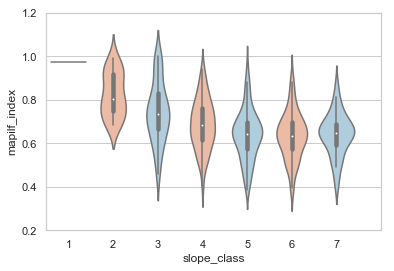

In [134]:
pal = sns.color_palette("RdBu_r", 2)
sns.violinplot(x = "slope_class", y = "mapilf_index", alpha = 1, 
           data = results_table, palette = pal)
plt.xlim(-0.5, 7)
plt.ylim(0.2, 1.2)
ax.set_xlabel('MAPILF Index')
ax.set_ylabel('TWI')

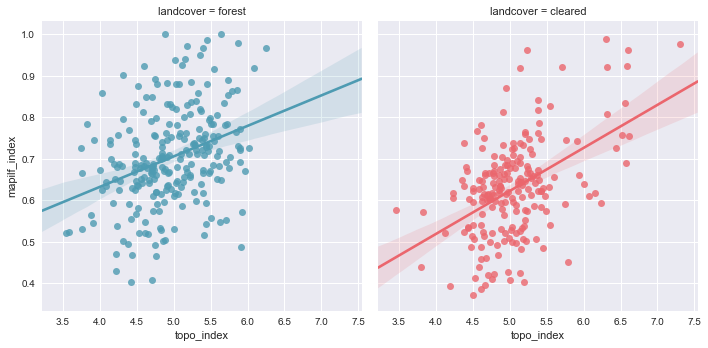

In [150]:
pal = sns.diverging_palette(220, 10, l=60, n=2, center = "dark")
sns.lmplot(x="topo_index", y = "mapilf_index", col = "landcover", 
           hue = "landcover", data = results_table, palette = pal)


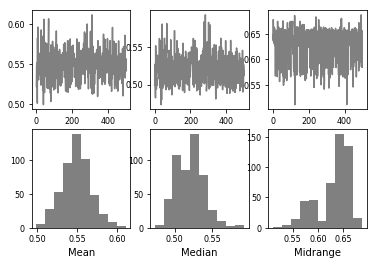

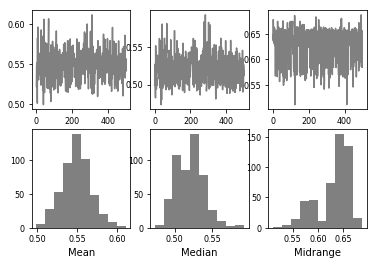

In [523]:
from pandas.plotting import bootstrap_plot
m = results_table['mapilf_index']
bootstrap_plot(m, size = 50, samples = 500, color = 'grey')